In [1]:
import pandas as pd
import xml.etree.ElementTree as ET
from SPARQLWrapper import SPARQLWrapper, JSON
from rebel_finetuning_faro import make_predictions

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mike-\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
data = pd.read_csv('data/predictions_100_relations.csv')
data = data.drop(['Unnamed: 0.1', 'Unnamed: 0',  'prediction'], axis=1)
data['path'] = data['path'].apply(lambda x: str(x)[60:]) #Only keep the general folder structure

In [14]:
data.head()

,path,sentence,subject,relation,object
0,afp_2021/2021/03/03/afp.com-20210303T141025Z-T...,India skipper Virat Kohli on Wednesday credite...,moaning,cause,fuelled
1,afp_2021/2021/03/03/afp.com-20210303T141025Z-T...,"""There is always too much noise and too much c...",spinning,cause,noise
2,afp_2021/2021/03/03/afp.com-20210303T141025Z-T...,"""The reason for our success has been that we h...",cribbed,cause,continue
3,afp_2021/2021/03/03/afp.com-20210303T141025Z-T...,England captain Joe Root said Test players sho...,captain,enable,management
4,afp_2021/2021/03/03/afp.com-20210303T141025Z-T...,"""I think that's part and parcel of Test cricke...",noise,cause,opinion


In [15]:
#This could probably be made a lot more efficiently
#Extract the PublicIdentifiers from the files that are in the prediction dataset
paths = data['path'].unique() #Extract all the unique paths
public_ids = {}
for path in paths:
    tree = ET.parse(f"data/{path}")
    f = tree.find('NewsItem') #Traverse down the xml file
    public_ids[path] = list(f.iter('PublicIdentifier'))[0].text

data['PublicID'] = data['path'].map(public_ids)
del public_ids
data.head()

,path,sentence,subject,relation,object,PublicID
0,afp_2021/2021/03/03/afp.com-20210303T141025Z-T...,India skipper Virat Kohli on Wednesday credite...,moaning,cause,fuelled,urn:newsml:afp.com:20210303T141025Z:TX-PAR-TVY...
1,afp_2021/2021/03/03/afp.com-20210303T141025Z-T...,"""There is always too much noise and too much c...",spinning,cause,noise,urn:newsml:afp.com:20210303T141025Z:TX-PAR-TVY...
2,afp_2021/2021/03/03/afp.com-20210303T141025Z-T...,"""The reason for our success has been that we h...",cribbed,cause,continue,urn:newsml:afp.com:20210303T141025Z:TX-PAR-TVY...
3,afp_2021/2021/03/03/afp.com-20210303T141025Z-T...,England captain Joe Root said Test players sho...,captain,enable,management,urn:newsml:afp.com:20210303T141025Z:TX-PAR-TVY...
4,afp_2021/2021/03/03/afp.com-20210303T141025Z-T...,"""I think that's part and parcel of Test cricke...",noise,cause,opinion,urn:newsml:afp.com:20210303T141025Z:TX-PAR-TVY...


In [16]:
#Add Asrael's URI's to the dataset. Note that some ID's can't be matched
URIs = pd.read_csv("Data/ASRAEL_data.csv")
data = data.join(URIs.set_index('Identifier'), on='PublicID')
data = data.dropna() #For now remove the rows which don't have an URI.
del URIs
data.head()

,path,sentence,subject,relation,object,PublicID,URI
34,afp_2021/2021/03/03/afp.com-20210303T213355Z-T...,Brazil registered a record of Covid-19 deaths ...,registered,cause,lost,urn:newsml:afp.com:20210303T213355Z:TX-PAR-TWM...,http://asrael.eurecom.fr/news/9cd8075b-2e65-36...
35,afp_2021/2021/03/03/afp.com-20210303T213355Z-T...,With a surge in cases currently pushing health...,surge,cause,recorded,urn:newsml:afp.com:20210303T213355Z:TX-PAR-TWM...,http://asrael.eurecom.fr/news/9cd8075b-2e65-36...
36,afp_2021/2021/03/03/afp.com-20210303T074352Z-T...,At least 10 rockets hit a military base in wes...,visit,cause,hit,urn:newsml:afp.com:20210303T074352Z:TX-PAR-TVP...,http://asrael.eurecom.fr/news/35f2598c-5036-34...
37,afp_2021/2021/03/03/afp.com-20210303T074352Z-T...,The Ain al-Assad base hosts Iraqi forces as we...,coalition,enable,fight,urn:newsml:afp.com:20210303T074352Z:TX-PAR-TVP...,http://asrael.eurecom.fr/news/35f2598c-5036-34...
38,afp_2021/2021/03/03/afp.com-20210303T074352Z-T...,Coalition spokesman Colonel Wayne Marotto conf...,hit,cause,provide,urn:newsml:afp.com:20210303T074352Z:TX-PAR-TVP...,http://asrael.eurecom.fr/news/35f2598c-5036-34...


In [22]:
#Create a graph based on the created dataframe

from rdflib import Graph, Literal, RDF, URIRef, OWL, Namespace
from resources import *

rnews = Namespace("http://iptc.org/std/rNews/2011-10-07#")
nif = Namespace("http://persistence.uni-leipzig.org/nlp2rdf/ontologies/nif-core#")
faro = Namespace("https://purl.org/faro/")

faro_classes = {'cause': faro.causes, 'enable': faro.enables, 'intend': faro.intends_to_cause, 'prevent': faro.prevents} #dict of faro definitions

graph = Graph()

for index, row in data.iterrows():

    graph.add((URIRef(row['URI']), RDF.type, rnews.Article)) #Add the URI as article
    graph.add((URIRef(row['URI']), rnews.identifier, Literal(row['PublicID']))) #Link the PublicID to the article
    sentence_uri = node_creation('', row['sentence'], base_add='/sentence') #Generate the URI for the sentence
    graph.add((URIRef(row['URI']), nif.sentence, sentence_uri)) #Link the article to the sentence
    graph.add((sentence_uri, RDF.type, nif.Sentence)) #Make the sentence URI of class 'Sentence'
    graph.add((sentence_uri, RDF.value, Literal(row['sentence']))) #Set the value of the URI equal to the sentence

    subject_uri = node_creation('', row['subject'] + str(sentence_uri), base_add='/subject') #Generate the URI for the subject, for now add the uri of sentence to make it unique
    graph.add((sentence_uri, faro.Relata, subject_uri)) #Add the subject to the sentence
    graph.add((subject_uri, RDF.value, Literal(row['subject']))) #Set the value of the subject URI equal to the subject

    object_uri = node_creation('', row['object'] + str(sentence_uri), base_add='/object') #Generate the URI for the object, for now add the uri of sentence to make it unique
    graph.add((sentence_uri, faro.Relata, object_uri)) #Add the object to the sentence
    graph.add((object_uri, RDF.value, Literal(row['object']))) #Set the value of the subject URI equal to the object

    graph.add((subject_uri, faro_classes[row['relation']], object_uri)) #Add relation betwee NERs

graph.serialize('Data/examples/first_sentence_ner.ttl', format='turtle')

<Graph identifier=Na6cbd695764a4a6bbaa3011b53e0a71e (<class 'rdflib.graph.Graph'>)>

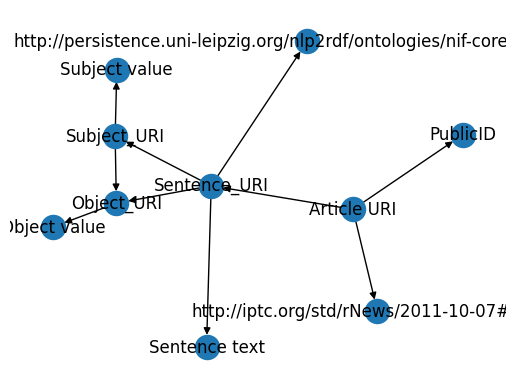

In [38]:
import networkx as nx
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph

nx_graph = rdflib_to_networkx_multidigraph(graph)
pos = nx.spring_layout(nx_graph, scale=2)

edge_labels = nx.get_edge_attributes(nx_graph, 'r')
nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=edge_labels)
nx.draw(nx_graph, with_labels=True)

# New format

In [1]:
#This converts the data into the right format, by removing uneccessary tokens in text and converting the wikidata link to text
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON

data = pd.read_csv('Data/ASRAEL_data_full.csv').head(1)
data['Text'] = data['Text'].apply(lambda x: str(x)[23:-38]) #Strip the beginning and end
data['Text'] = data['Text'].apply(lambda x: str(x).replace('</p><p>', ''))
#data= data.drop_duplicates(subset=['URI', 'Identifier', 'Event', 'Location', 'Text'])

event_mapping = {}

sparql = SPARQLWrapper(
    "https://query.wikidata.org/sparql"
)
sparql.setReturnFormat(JSON)

for event in data['Event'].unique().tolist():
    event_ = f"wd:{event.split('/')[-1]}"

    sparql.setQuery("""
    SELECT ?item WHERE {
    %s rdfs:label ?item.
    FILTER (lang(?item) = 'en')
} """ % (event_))

    try:
        ret = sparql.queryAndConvert()
        event_name = ret['results']['bindings'][0]['item']['value']

    except Exception as e:
        event_name = None

    event_mapping[event] = event_name

data['Event'] = data['Event'].map(event_mapping)

#This is not good, this has to be changed so that there are separate columns for the events
data = data.groupby(['URI','Identifier','Location', 'Time', 'Text']).agg({'Event': lambda x: list(x)}).reset_index(drop=False)
#data[data['Identifier'] == 'urn:newsml:afp.com:20210114T051621Z:TX-PAR-SGI29:1'] to test

In [13]:
from rdflib import Graph, Literal, RDF, URIRef, OWL, Namespace
from resources import *
from rebel_finetuning_faro import make_predictions

rnews = Namespace("http://iptc.org/std/rNews/2011-10-07#")
nif = Namespace("http://persistence.uni-leipzig.org/nlp2rdf/ontologies/nif-core#")
faro = Namespace("https://purl.org/faro/")

faro_classes = {'cause': faro.causes, 'enable': faro.enables, 'intend': faro.intends_to_cause, 'prevent': faro.prevents} #dict of faro definitions

graph = Graph()

for index, row in data.iterrows():

    graph.add((URIRef(row['URI']), RDF.type, rnews.Article)) #Add the URI as article
    graph.add((URIRef(row['URI']), rnews.identifier, Literal(row['Identifier']))) #Link the PublicID to the article

    sentences, predictions = make_predictions(row['Text'].split('.'), 'rebel_finetuned.pth')
    for sentence, prediction in zip(sentences, predictions):
        sentence_uri = node_creation('', sentence, base_add='/sentence') #Generate the URI for the sentence
        graph.add((URIRef(row['URI']), nif.sentence, sentence_uri)) #Link the article to the sentence
        graph.add((sentence_uri, RDF.type, nif.Sentence)) #Make the sentence URI of class 'Sentence'
        graph.add((sentence_uri, RDF.value, Literal(sentence))) #Set the value of the URI equal to the sentence

        subject_uri = node_creation('', prediction[0] + str(sentence_uri), base_add='/subject') #Generate the URI for the subject, for now add the uri of sentence to make it unique
        graph.add((sentence_uri, faro.Relata, subject_uri)) #Add the subject to the sentence
        graph.add((subject_uri, RDF.value, Literal(prediction[0]))) #Set the value of the subject URI equal to the subject

        object_uri = node_creation('', prediction[2] + str(sentence_uri), base_add='/object') #Generate the URI for the object, for now add the uri of sentence to make it unique
        graph.add((sentence_uri, faro.Relata, object_uri)) #Add the object to the sentence
        graph.add((object_uri, RDF.value, Literal(prediction[2]))) #Set the value of the subject URI equal to the object

        graph.add((subject_uri, faro_classes[prediction[1]], object_uri)) #Add relation betwee NERs
        break

    break

#graph.serialize('Data/examples/first_sentence_ner.ttl', format='turtle')

C:\Users\mike-\Documents\VU\Eurecom\KG_mapping\venv\lib\site-packages\transformers\generation\utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 200 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


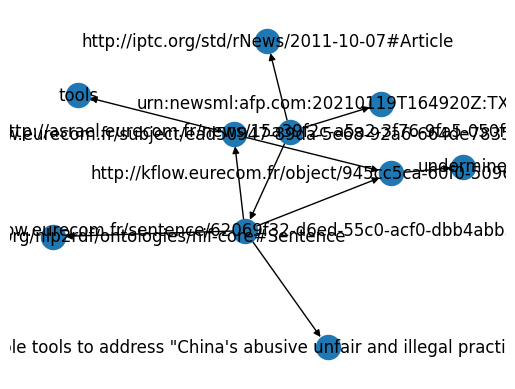

In [21]:
import networkx as nx
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph

nx_graph = rdflib_to_networkx_multidigraph(graph)
pos = nx.spring_layout(nx_graph, scale=2)

edge_labels = nx.get_edge_attributes(nx_graph, 'r')
nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=edge_labels)
nx.draw(nx_graph, with_labels=True)